## Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
from openmm.unit import Quantity, Unit
import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm


/tmp/ipykernel_4040603/123884183.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*            

## Loading data and creating atom group of ions

In [2]:
u = mda.Universe('md.gro', 'md.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname NA CL')

u1 = mda.Universe('mdr1.gro', 'mdr1.xtc')
u1.transfer_to_memory()
ions1= u1.select_atoms('resname NA CL')

u2 = mda.Universe('mdr2.gro', 'mdr2.xtc')
u2.transfer_to_memory()
ions2= u2.select_atoms('resname NA CL')

u3 = mda.Universe('mdr3.gro', 'mdr3.xtc')
u3.transfer_to_memory()
ions3= u3.select_atoms('resname NA CL')




## Function for calculating osmotic values:

In [3]:
def SPW_analysis(u, ions, repnum):

## loading data
        
    if repnum == 0:
        print("Data for original run")
    else:
        print("Data for replicate #",repnum)

    box_size = u.dimensions[:3] * angstrom
    wall1=box_size[2]/2-24*angstrom
    wall2=box_size[2]/2+24*angstrom
    R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

## calculation of osmotic values

    def osmotic_values(mean_force_wall, molarity :Quantity, vant_hoff : int=2, T=300*kelvin, cross_sectional_area : Quantity=48*48 * angstrom**2 ):
        osm_press=mean_force_wall/cross_sectional_area
        osm_bar = osm_press.in_units_of(bar / mole)
        osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
        print(f"Osmotic Pressure Observed:", osm_bar)
        osm_press_ideal=vant_hoff*molarity*R*T
        osm_press_ideal=osm_press_ideal.in_units_of(bar)
        print(f"Osmotic Pressure Ideal:", osm_press_ideal)
        osm_coeff=osm_bar/osm_press_ideal
        print(f"Osmotic Coefficient:", osm_coeff)

        return osm_coeff

    def calculate_net_force(z_values : np.ndarray[float], zwall : float, k : float) -> float:
        return k * abs(z_values - zwall).sum()

## calculation of mean force

    k_nm = 4184 * kilojoule_per_mole / nanometer**2
    k = k_nm.in_units_of(kilojoule_per_mole / angstrom**2)

    walls_z_pos = np.array([48, 96]) * angstrom
    forces_at_ts = {
        48 : [],
        96 : []
    }

    for _ in u.trajectory:
        ions_z = ions.positions[:,2]*angstrom
        force_48 = calculate_net_force(
            z_values=ions_z[ions_z < wall1],
            zwall=wall1,
            k=k
        )
        forces_at_ts[48].append(force_48)

        force_96 = calculate_net_force(
            z_values=ions_z[ions_z > wall2],
            zwall=wall2,
            k=k
        )
        forces_at_ts[96].append(force_96)

    mean_forces = {
        abs_wall_z : sum(force_list, start=0*(kilojoule_per_mole / angstrom)) / len(u.trajectory)
            for abs_wall_z, force_list in forces_at_ts.items()
    }

    print('mean forces =', mean_forces)

    box_x = box_size[0]
    box_y = box_size[1]

    A_box = box_x * box_y 

    dim_mem = walls_z_pos.ptp() * walls_z_pos.unit
    V_mem = A_box * dim_mem
    #print(V_mem)

    n_part = 65
    M = n_part / (V_mem * AVOGADRO_CONSTANT_NA)
    M = M.in_units_of(mole / litre)
    #print(M)

## calling calculation of osmotic values
    
    for wall_z_val, mF in mean_forces.items():
        print(wall_z_val)
        o = osmotic_values(mF, molarity=M, cross_sectional_area=A_box)


    print("\nAverage between 2 walls: ")
    av_mF=(mean_forces[48]+mean_forces[96])/2
    o = osmotic_values(av_mF, molarity=M, cross_sectional_area=A_box)

## number of ions per z coordinate (both observed through the system and outside the walls)
    ions_at_48=[]
    ions_at_96=[]
    zpositions=[]

    for _ in u.trajectory:
        ions_z = ions.positions[:,2]*angstrom
        zpositions.append(ions_z)
        z_values48=ions_z[ions_z < wall1]
        z_values96=ions_z[ions_z > wall2]
        ions_at_48.append(z_values48)
        ions_at_96.append(z_values96)

    # plt.hist(ions_at_48,bins='auto',edgecolor='blue')
    # plt.xlabel('z coordinates (A)')
    # plt.ylabel('Number of Ions')
    # plt.title('Number of ions outside of wall at 4.8 nm')
    # plt.axis([47, 48, 0, 2.5])
    # # Display the plot
    # plt.grid(True)
    # plt.show()

    # plt.hist(ions_at_96,bins='auto',edgecolor='red')
    # plt.xlabel('z coordinates (A)')
    # plt.ylabel('Number of Ions')
    # plt.title('Number of ions outside of wall at 9.6 nm')
    # plt.axis([96, 97, 0, 2.5])
    # plt.grid(True)
    # plt.show()

    # plt.hist(zpositions,bins='auto',edgecolor='green')
    # plt.xlabel('z coordinates (A)')
    # plt.ylabel('Number of Ions')
    # plt.title('Number of ions per z coordinate')
    # plt.grid(True)
    # plt.show()

## plotting force vs time

    list48=forces_at_ts[48]
    list96=forces_at_ts[96]
    f48=[]
    f96=[]
    time=[]
    for i,ts in enumerate(u.trajectory):
        time.append(u.trajectory.time)
        val48=list48[i]
        val96=list96[i]
        f48.append(val48.item())
        f96.append(val96.item())

    plt.plot(time,f96, color='r', label='9.6 nm')
    plt.plot(time,f48, color='g', label='4.8 nm')
    plt.ylabel("Forces")
    plt.xlabel("Time")
    plt.title("Forces vs time")
    plt.legend()
    plt.show()


## calculation of autocorrelation function and plot of uncorrelated samples
    
    fts48=np.array(f48)
    fts96=np.array(f96)

    nskip=100
    t0, g, Neff_max = timeseries.detect_equilibration(fts48,nskip=nskip) # compute indices of uncorrelated timeseries
    fts48_equil = fts48[t0:]
    indices48 = timeseries.subsample_correlated_data(fts48_equil, g=g)
    fts48_s = fts48_equil[indices48]

    indt48=[]
    for i in indices48:
        indt48.append(time[i])

    print('t0 =', t0,' g =',g,' Neff_max =', Neff_max)

    plt.plot(time,f48)
    plt.scatter(indt48, fts48_s, color='m', marker='o')
    plt.ylabel("Forces")
    plt.xlabel("Time")
    plt.title("Forces at 4.8 nm Wall")
    plt.show()

    t0, g, Neff_max = timeseries.detect_equilibration(fts96,nskip=nskip) # compute indices of uncorrelated timeseries
    fts96_equil = fts96[t0:]
    indices96 = timeseries.subsample_correlated_data(fts96_equil, g=g)
    fts96_s = fts96_equil[indices96]

    indt96=[]
    for i in indices96:
        indt96.append(time[i])

    print('t0 =', t0,' g =',g,' Neff_max =', Neff_max)

    plt.plot(time, f96, c='g')
    plt.scatter(indt96, fts96_s, color='m', marker='o')
    plt.ylabel("Forces")
    plt.xlabel("Time")
    plt.title("Forces at 9.6 nm Wall")
    plt.show()

Data for original run
mean forces = {48: Quantity(value=5.163277604963392, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=5.331079182658189, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 37.21277854906911 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7643071474317701
96
Osmotic Pressure Observed: 38.422158216150784 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7891463978062171

Average between 2 walls: 
Osmotic Pressure Observed: 37.817468382609945 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7767267726189936


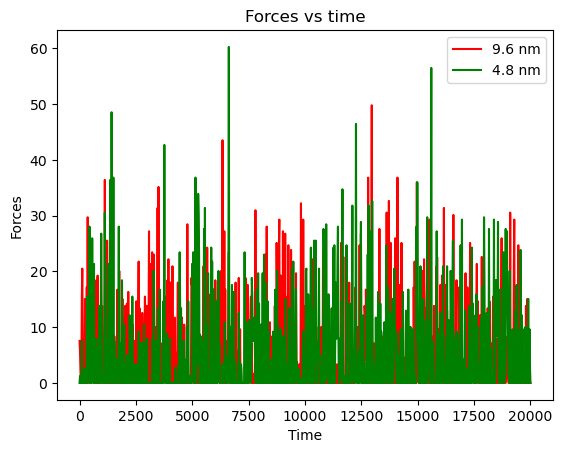

t0 = 100  g = 1.3566633  Neff_max = 664.8665


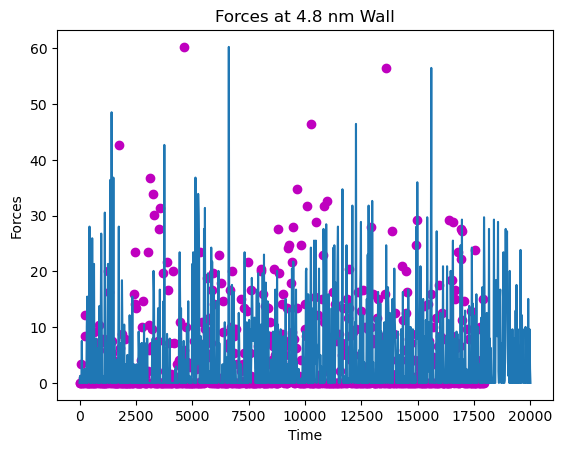

t0 = 0  g = 1.931484  Neff_max = 518.7721


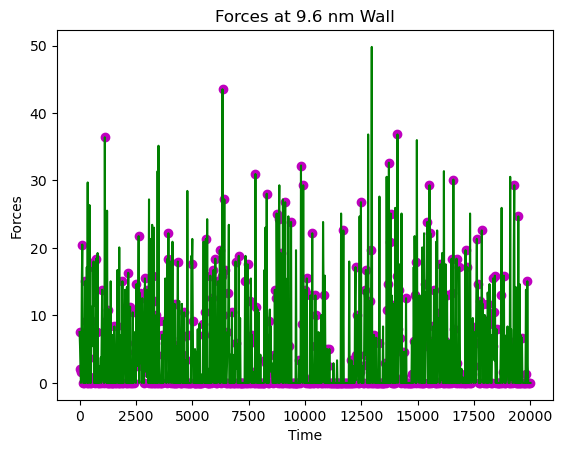

In [13]:
o=SPW_analysis(u,ions,0)


Data for replicate # 1
mean forces = {48: Quantity(value=4.6211610950694775, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=5.092836894550785, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 33.30563599855356 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.6840589882287125
96
Osmotic Pressure Observed: 36.70509820375828 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7538799841921308

Average between 2 walls: 
Osmotic Pressure Observed: 35.005367101155926 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7189694862104217


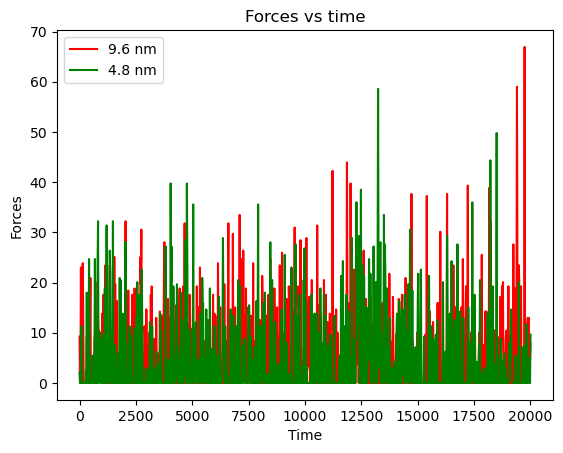

t0 = 300  g = 1.9893255  Neff_max = 352.88342


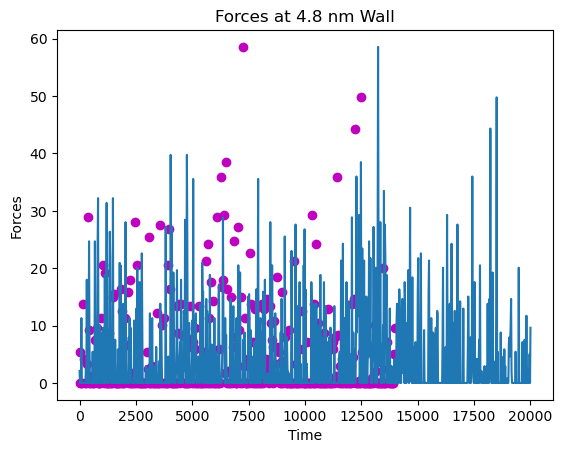

t0 = 0  g = 1.0  Neff_max = 1002.0


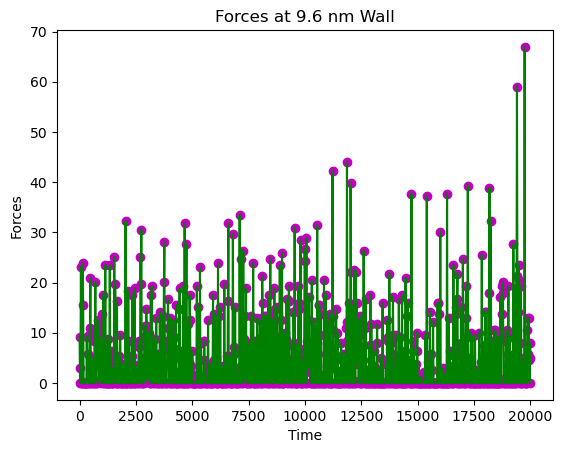

In [5]:
r1=SPW_analysis(u1,ions1,1)


Data for replicate # 2
mean forces = {48: Quantity(value=4.927957032591426, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=4.957389125157087, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 35.51677592869862 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7294732281343195
96
Osmotic Pressure Observed: 35.728898930148084 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7338299876256518

Average between 2 walls: 
Osmotic Pressure Observed: 35.622837429423356 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7316516078799857


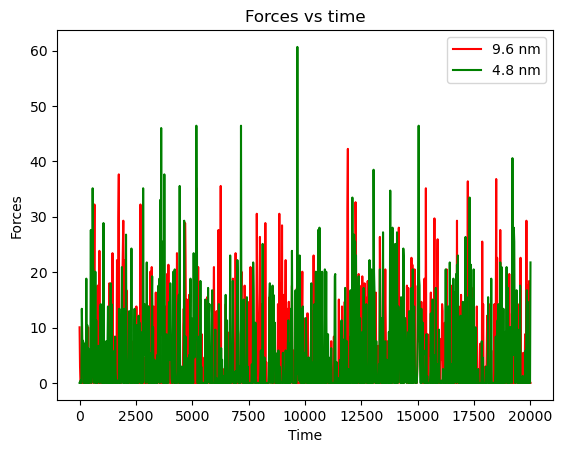

t0 = 200  g = 1.3163902  Neff_max = 609.2419


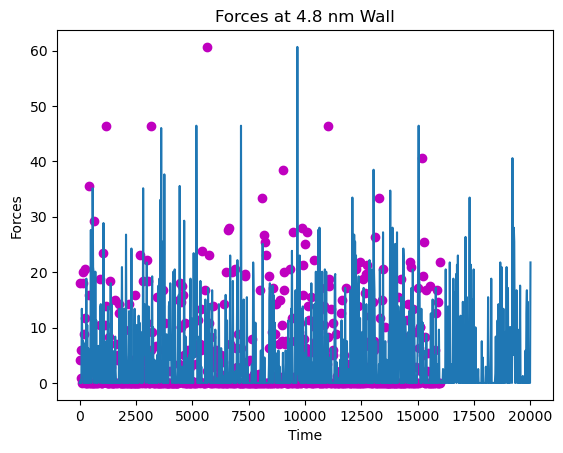

t0 = 100  g = 1.595798  Neff_max = 565.23444


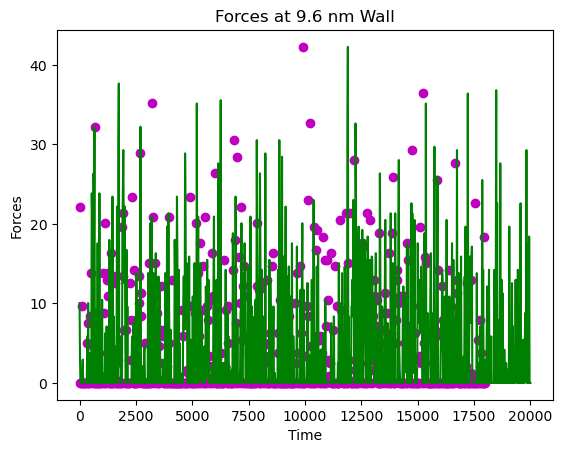

In [14]:
r2=SPW_analysis(u2,ions2,2)


Data for replicate # 3
mean forces = {48: Quantity(value=5.577073648092633, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=4.32372440608709, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 40.19508972727249 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.8255603469573274
96
Osmotic Pressure Observed: 31.161950052086148 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.6400301746163768

Average between 2 walls: 
Osmotic Pressure Observed: 35.67851988967932 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7327952607868522


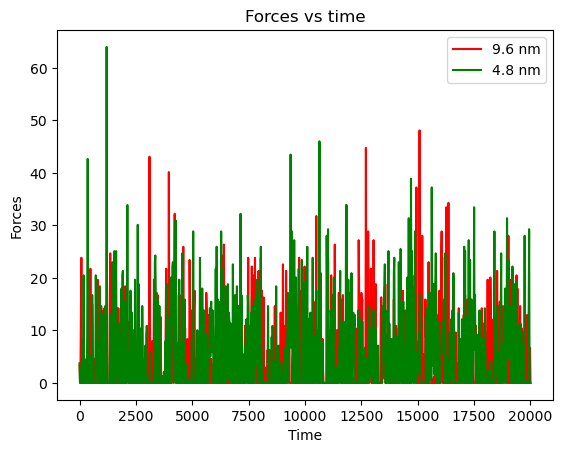

t0 = 0  g = 1.3262975  Neff_max = 755.4866


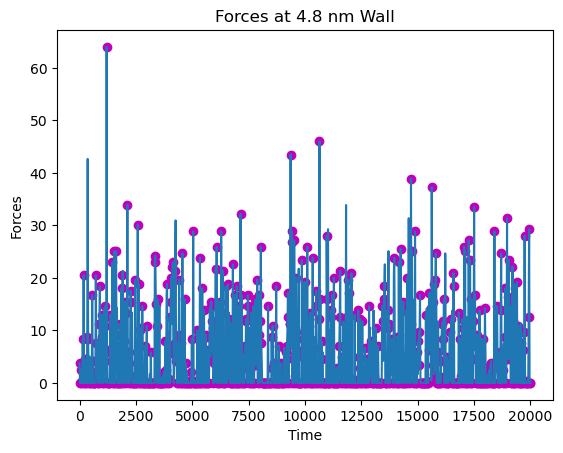

t0 = 400  g = 1.0  Neff_max = 602.0


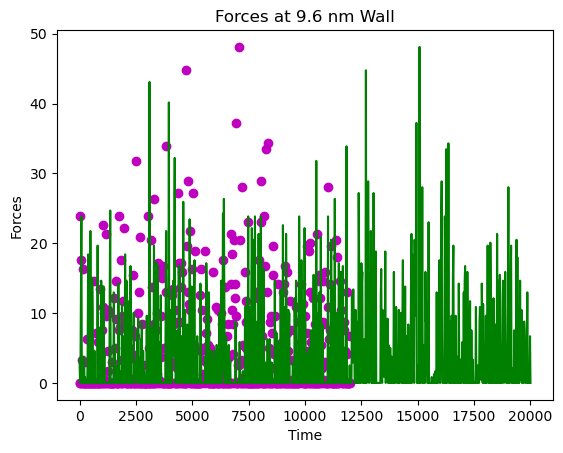

In [15]:
r3=SPW_analysis(u3,ions3,3)

### Density profiles using GROMACS

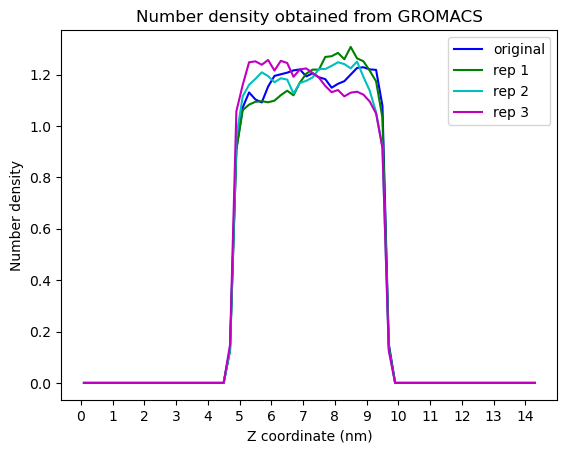

In [12]:
x,y = np.loadtxt("density_20ns_72.xvg",comments=["@", "#"],unpack=True)
x1,y1 = np.loadtxt("dens_r1.xvg",comments=["@", "#"],unpack=True)
x2,y2 = np.loadtxt("dens_r2.xvg",comments=["@", "#"],unpack=True)
x3,y3 = np.loadtxt("dens_r3.xvg",comments=["@", "#"],unpack=True)
plt.plot(x,y, c='b', label='original')
plt.plot(x1,y1, c='g', label='rep 1')
plt.plot(x2,y2, c='c', label='rep 2')
plt.plot(x3,y3, c='m', label='rep 3')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Number density")
plt.xticks(np.arange(0, 14.4, 1.0))
plt.title('Number density obtained from GROMACS')
plt.legend()
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()

## Density profiles using MDanalysis

In [9]:
def density_profile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    bins = np.linspace(0, box, num=n_bins)

    counts = np.zeros(n_bins-1)
        
    if len(universe.trajectory) == 0:
        for b in tqdm(range(n_bins-1)):
            lb = bins[b]
            ub = bins[b+1]
            bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)
            if method in ['atom', 'atoms', 'all']:
                counts[b] += len(bin_atoms)
            elif method in ['molecule', 'mol', 'residue', 'res']: 
                counts[b] += bin_atoms.n_residues
            elif method in ['mass', 'mass density']:
                box_dims = [box[i] for i in range(3) if i != d]
                dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                mass = bin_atoms.masses.sum() / 6.022 / 10**23
                counts[b] += mass / dV
    else:
        for ts in tqdm(universe.trajectory[::frameby]):
            for b in range(n_bins-1):
                lb = bins[b]
                ub = bins[b+1]
                bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)

                if method in ['atom', 'atoms', 'all', 'number']:
                    counts[b] += len(bin_atoms)                 
                elif method in ['molecule', 'mol', 'residue', 'res']: 
                    counts[b] += bin_atoms.n_residues
                elif method in ['mass', 'mass density']:
                    box_dims = [box[i] for i in range(3) if i != d]
                    dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                    mass = bin_atoms.masses.sum() / 6.022 / 10**23
                    counts[b] += mass / dV

        counts = counts / len(universe.trajectory[::frameby])

    return bins, counts

In [10]:
nbins,ncounts=density_profile(u,ions,2)
nbins1,ncounts1=density_profile(u1,ions1,2)
nbins2,ncounts2=density_profile(u2,ions2,2)
nbins3,ncounts3=density_profile(u3,ions3,2)


Calculating the partial density profile of <AtomGroup [<Atom 11101: NA of type NA of resname NA, resid 1 and segid SYSTEM>, <Atom 11102: NA of type NA of resname NA, resid 2 and segid SYSTEM>, <Atom 11103: NA of type NA of resname NA, resid 3 and segid SYSTEM>, ..., <Atom 11228: CL of type CL of resname CL, resid 63 and segid SYSTEM>, <Atom 11229: CL of type CL of resname CL, resid 64 and segid SYSTEM>, <Atom 11230: CL of type CL of resname CL, resid 65 and segid SYSTEM>]> in the z dimension...


100%|██████████| 1001/1001 [02:34<00:00,  6.47it/s]



Calculating the partial density profile of <AtomGroup [<Atom 11101: NA of type NA of resname NA, resid 1 and segid SYSTEM>, <Atom 11102: NA of type NA of resname NA, resid 2 and segid SYSTEM>, <Atom 11103: NA of type NA of resname NA, resid 3 and segid SYSTEM>, ..., <Atom 11228: CL of type CL of resname CL, resid 63 and segid SYSTEM>, <Atom 11229: CL of type CL of resname CL, resid 64 and segid SYSTEM>, <Atom 11230: CL of type CL of resname CL, resid 65 and segid SYSTEM>]> in the z dimension...


100%|██████████| 1001/1001 [02:34<00:00,  6.48it/s]



Calculating the partial density profile of <AtomGroup [<Atom 11101: NA of type NA of resname NA, resid 1 and segid SYSTEM>, <Atom 11102: NA of type NA of resname NA, resid 2 and segid SYSTEM>, <Atom 11103: NA of type NA of resname NA, resid 3 and segid SYSTEM>, ..., <Atom 11228: CL of type CL of resname CL, resid 63 and segid SYSTEM>, <Atom 11229: CL of type CL of resname CL, resid 64 and segid SYSTEM>, <Atom 11230: CL of type CL of resname CL, resid 65 and segid SYSTEM>]> in the z dimension...


100%|██████████| 1001/1001 [02:35<00:00,  6.45it/s]



Calculating the partial density profile of <AtomGroup [<Atom 11101: NA of type NA of resname NA, resid 1 and segid SYSTEM>, <Atom 11102: NA of type NA of resname NA, resid 2 and segid SYSTEM>, <Atom 11103: NA of type NA of resname NA, resid 3 and segid SYSTEM>, ..., <Atom 11228: CL of type CL of resname CL, resid 63 and segid SYSTEM>, <Atom 11229: CL of type CL of resname CL, resid 64 and segid SYSTEM>, <Atom 11230: CL of type CL of resname CL, resid 65 and segid SYSTEM>]> in the z dimension...


100%|██████████| 1001/1001 [02:35<00:00,  6.45it/s]


### Effect of changing number of bins

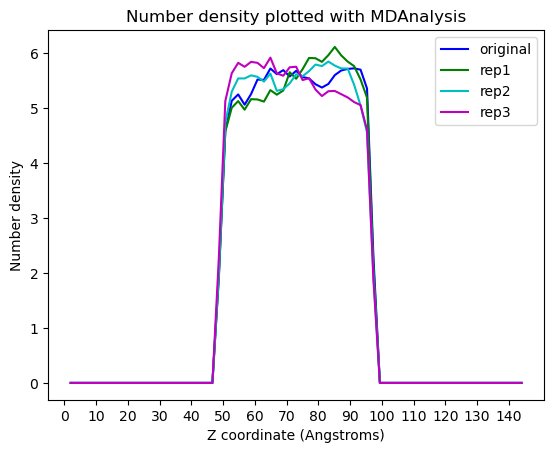

In [11]:
plt.plot(nbins[1:],ncounts, c='b', label='original')
plt.plot(nbins1[1:],ncounts1, c='g', label='rep1')
plt.plot(nbins2[1:],ncounts2, c='c', label='rep2')
plt.plot(nbins3[1:],ncounts3, c='m', label='rep3')

plt.xlabel("Z coordinate (Angstroms)")
plt.ylabel("Number density")
plt.xticks(np.arange(0, 144, 10))
plt.title("Number density plotted with MDAnalysis")
plt.legend()
plt.show()